# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      

* [GAN2](#GAN2)
    * [DCGAN](#DCGAN)
        * [Generator](#Generator)
        * [Discriminator](#Discriminator)


---
## GAN2


 | 구분1       |구분2       |
 |------------|-----------|
 |linear      | non-linear|
 |porbabilistic|stochastic|
 | parametric |non parametric|
 |black box   |  white box|
 |discriminant| generative|


### discriminant model
- 값이 들어올때 decision boundary(결정평면) 찾아서 어떤 class인지 분류 

### generative model
 - 각 데이터의 확률 분포를 추정하고 분포를 기반으로한 새로운 데이터 분류/생성
  > - autoencoder 고차원 데이터를 저차원으로 축소한것이 고유의 특성을 찾았어서 생성에 활용

### Generative Adversarial Network

> "최근 10년간  ml분야에서 가장 혁신적인 아이디어" -Yann LeCun-


- 실제처럼 만들고 구분할 수 있도록 서로 **적대적 경쟁(Adversarial)시키면서 발전** 
- generator 위조범과 discriminator 위조를 구분해내려는 자의 경쟁
  - 실제 이미지의 특성을 찾아내기 위해서 틀릴때마다 feedback 을 받으면서 실제처럼 생성
  - 데이터의 숨어있는 분포를 찾아서 데이터 생성
- generator :가짜 데이터 생성
- discriminator: 가짜 데이터 여부 구별
  > - 지식 증류(힌모델이 다르모델에 도움)

> autoencoder : 자기 값을 이용해서 고유의 특징을 찾음 

> Ian Goodfellow: Adversarial 은 NN아닌 어떠한 모델도 사용 가능.
    - stanford: Intro to statistical learning

  | ML    |Stat |
  |-------|-----|
  |Network|model|


#### 학습 테크닉 정리
GAN 학습이 힘듦

  - cherry picking

- overfitting 막는 방법
  - 데이터 확보
    - data augmentation 
    - noise
  - 데이터 전처리
    - normalization : 0 ~ 1, -1 ~ 1 ( 0 centered 방향 틂)
  - 모델 단순화
    - feature 수 줄이기:
      - feature selection(데이터 변형 없이 제외함)
        1. filter
        2. wrapper
        3. embeded
      - dimensionality reduction
        - 데이터를 삭제하는것이 아닌 합쳐서 변형
    - regularizer (weight decay) 모델 복잡하지 않게 규제
    - L1,L2
  - ensemble
    - dropout
  - early stopping

- **underfitting** 막는 방법
  - Normalization
    - BN : b4 activation
    - layer
    - instance
    - weight 
  - ReLU, Leacky ReLU
  - initializer
    - Xavier initializer
  - gradient clipping
  - optimizer
  - learning rate decay
    - callbacks - Plataeu 고원현상

bias:BN sclae&size factor 학습속도에 영향줌

- 생성모델은 overfitting시키려하지만 underfitting되는 경우가 더 많음
> - loss graph 변화량으로 학습 잘 되는지 안 되는지 확인

### DCGAN
- Deep Convolutional GAN

TensorFlow DCGAN 참고: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

In [1]:
import tensorflow as tf

In [2]:
(X_train, y_train),(_,_) =tf.keras.datasets.mnist.load_data() #overfitting 검증할 필요가 없어서 train만 사용

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train=X_train.reshape(-1,28,28,1) #3차원

### 데이터 전처리
- 정규화 
    - [0,1] 정규화 :$\frac{x-min}{Max-min}$
    - [-1,1] 정규화( zero-centered) :x-m/ (M-m/2) 0~2 ->평행이동 

In [4]:
X_train=( X_train- 255/2) /(255/2) #zero-centered 

train_on_batch
- gradient tape쓰기 위해서 batch_size
- tensor형태
 - from_tensor_slices:numpy->tensor->GradientTape

In [2]:
BATCH_SIZE = 256
train= tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE) 

NameError: name 'tf' is not defined

모델을 generator , discriminator나누어서 모델 만듦

## Generator
- 학습을 통해서 데이터의 숨어있 분포를 찾아서 받은후 convolution해서 image생성


- BatchNormalization
  - tensorflow에서 알아서 조절
  - activation function 이전
- LeakyReLU
  - ReLU 확장판으로 학습이 잘 안되는 문제가 생겨서 0 가까운 기울기를 만들어서 0 안갖도록 해서 0이 되지않음(비선형)
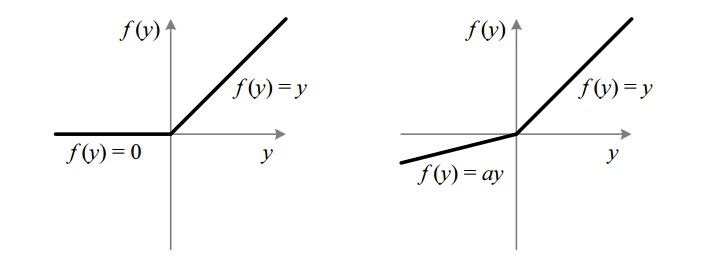

> - autoencoder encoder+decoder
    - upsampling
    - Conv2DTranspose-학습통해서 함
- filter size:  vgg (3,3),(5,5)충분
- use_bias=False 학습 잘 안됨.. 풍부해지나
- stride큰거 쓰면 pooling 대신함
- 갯수 맞추기위해서 padding='same'

In [13]:
NOISE_DIM=100

def make_generative_model(): #함수로 재활용
  generative_model= tf.keras.models.Sequential([ #첫번째 convolution갯수 맞춰야함
                                                tf.keras.layers.Dense(7*7*256,input_shape=(NOISE_DIM,),use_bias=False),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.LeakyReLU(),
                                                
                                                tf.keras.layers.Reshape((7, 7, 256)),#convolution형태

                                                tf.keras.layers.Conv2DTranspose(128,(5,5),padding='same',use_bias=False) , 
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.LeakyReLU(),

                                                tf.keras.layers.Conv2DTranspose(128,(5,5),padding='same', strides=2,use_bias=False) ,
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.LeakyReLU(),
                                                #마지막 레이어 1 
                                                tf.keras.layers.Conv2DTranspose(1,(5,5),padding='same',strides=2,use_bias=False) , # vgg (3,3),(5,5)
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.LeakyReLU(),
                                                ])
  return generative_model

In [8]:
7*7*256 #크기 꼭 맞춰야됨...

12544

In [14]:
generator= make_generative_model()

generator.summary() #28x28x1로 맞춤

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

- sequential로 하면 list이기 때문에 model에 레이어 하나씩 추가해서 assert 참이 아니면 에러를 발생시켜서 확인

In [7]:
a=1
assert a==2

AssertionError: ignored

- 아직 훈련되지 않은 generator가 이미지 생성


In [15]:
img=generator(tf.random.normal([1,100])) 
img.numpy().reshape(1,28,28) 

array([[[ 1.92821247e-03, -1.89562605e-04,  3.23843487e-05,
          2.74822069e-03,  7.99591746e-03, -8.92840384e-04,
          1.10335553e-04,  5.01927687e-03,  9.27320123e-03,
         -6.38830010e-04,  2.51494488e-03,  3.93840391e-03,
          7.51121435e-03, -2.58055981e-03,  6.60296017e-03,
          4.80051246e-03,  9.38823447e-03,  2.29550689e-03,
          9.14195646e-03, -4.94459762e-08,  5.74209914e-03,
         -1.56374357e-03,  1.18985474e-02,  3.52874584e-03,
         -9.91399167e-04, -5.89414558e-04,  2.41298461e-03,
          3.79810971e-03],
        [-4.92327090e-04, -9.02793603e-04, -2.03953823e-03,
         -1.43754529e-03, -5.83510438e-04, -1.04212516e-03,
          1.62379742e-02, -3.98835022e-04,  1.00268656e-02,
         -2.53691827e-03,  2.94715888e-03,  1.64132845e-02,
          5.60334418e-03, -3.39009729e-03, -1.46871188e-03,
         -1.86229637e-03,  1.69436466e-02, -5.66716213e-03,
         -3.12698772e-04, -3.95422801e-03,  1.32316537e-02,
         -5.2

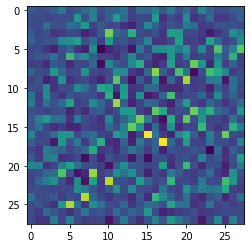

In [16]:
import matplotlib.pyplot as plt
plt.imshow(img.numpy().reshape(28,28)) 

## Discriminator
- 번갈아가면서 학습시켜서 진짜인지 구분 가능하는 능력을 키움
- CNN기반 분류기이므로 generator구조 맞출 필요 없음
> - autoencoder 압축- 압축한것을 복원해야해서 동일하게 맞춰야함
- 생성자가 핵심이기 때문에 Discriminator 단순

In [17]:
discriminator= tf.keras.models.Sequential([
                                           tf.keras.layers.Conv2D(64,(5,5),input_shape=(28,28,1)),
                                           tf.keras.layers.LeakyReLU(),
                                           tf.keras.layers.Dropout(0.3),

                                           tf.keras.layers.Conv2D(128,(5,5)),
                                           tf.keras.layers.LeakyReLU(),
                                           tf.keras.layers.Dropout(0.3),

                                           tf.keras.layers.Flatten(),
    
                                           tf.keras.layers.Dense(1) #prediction                       
                                           ])

In [18]:
discriminator.summary() #구성

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)            

훈련되지않은 discriminator 사용하여 판별
- 음수 :가짜
- 양수 :진짜

In [19]:
discriminator(img)  #아직 학습 안해서 생성자의 이미지를 판단 능력 없음

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00010934]], dtype=float32)>

학습테크닉
- comiple : simoid를 안한경우 loss에서 from_logits=True
  - 마지막 레이어에 activation 안 써도 logit tensor로 바꿔줌 0~1
  - numerical stability

In [20]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) # functional paradigm
#문자열,함수,객체-재활용

### Discriminator Loss
- 생성된 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화
  - multi-task loss  가짜 이미지 예측(0) ,진짜 이미지 예측(1) 

- 객체 상속, 재활용,인스턴스한 객체() 함수처럼 사용 
    - __call__-> callable -> functional paradigm
 - loss( y_true, y_pred)

In [22]:
def discriminator_loss(real,fake):
  real_loss= loss(tf.ones_like(real),real)
  fake_loss= loss(tf.zeros_like(fake),fake)
  
  total_loss=real_loss+fake_loss
  return total_loss

### Generator Loss
- 감별자를 얼마나 잘 속였는지에 대해 수치화
    - Discriminator 생성된 이미지를 진짜 (1)로 분류

In [31]:
def generative_loss(fake):
  return loss(tf.zeros_like(fake),fake)

### optimizer
- 감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 상이.

In [26]:
optimizer_g=tf.keras.optimizers.Adam( )
optimizer_d=tf.keras.optimizers.Adam() 

- fit:epoch 별
- train_on_batch :batch만큼
- GradientTape: for 이용해서 epoch별 batch size만큼

In [23]:
NOISE_DIM=100
noise =tf.random.normal([BATCH_SIZE,NOISE_DIM])
real=X_train

In [34]:
@tf.function
def train_step(real):
  with tf.GradientTape() as G, tf.GradientTape() as D: #알아서 순차적 실행 
    #training학습여부 조절
    imgs=generator(noise,training=True)  #뱃치사이즈 만큼 이미지 만듦

    real_img=discriminator(real, training=True)
    fake_img=discriminator(imgs, training=True) #제너레이터가만든 이미지

    gen_loss=generative_loss(fake_img)
    dis_loss=discriminator_loss(real_img, fake_img)

  gd=G.gradient(gen_loss,generator.trainable_variables)
  dd=D.gradient(dis_loss,discriminator.trainable_variables)
# print(gd)
  optimizer_g.apply_gradients(zip(gd,generator.trainable_variables) )
  optimizer_d.apply_gradients(zip(dd,discriminator.trainable_variables) )

- trainable=True/False 이용해서 학습시 weight update 여부 조절
- training 옵션 (합수형 패러다임)   
   > * `training`: Boolean scalar tensor of Python boolean indicating whether the `call` is meant for training or inference    - 코드 효율적 간략화하면서 번갈아가면서 학습 가능
   

> - autoencoder : 실제 분포가 있지만 노이즈 있으면 가짜 데이터, 학습을 통해서 노이즈 제거해서 실제분포 찾음
  - 노이즈 데이터와 실제데이터 비교해서 노이즈 제거
  - 노이즈 데이터로 실제값을 받으면 생성 학습을 통해서 노이즈 제거해서 실제 분포 찾아서 값 정확하게 예측 가능
  
 - train_on_batch(epoch 별 batch size나눠서 여러번 돌리면 fit)

In [1]:
#tf에서 17시간 15분 학습...
for e in range(50): #10 epochs
  for i in train:
    train_step(i)

NameError: name 'train' is not defined

In [ ]:
img=generator(tf.random.normal([1,100]))
plt.imshow(img.numpy().reshape(28,28))  #여러번 학습하면 패턴의 대칭이 점점 깨지기 시작

In [46]:
discriminator(img) 

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-29.158497]], dtype=float32)>

In [36]:
#디버깅용
for i in train:
  train_step(i)
  break

In [ ]:
import inspect
print(inspect.getsource(descriminator.__call__)) #소스 코드 

  def __call__(self, *args, **kwargs):
    """Wraps `call`, applying pre- and post-processing steps.

    Arguments:
      *args: Positional arguments to be passed to `self.call`.
      **kwargs: Keyword arguments to be passed to `self.call`.

    Returns:
      Output tensor(s).

    Note:
      - The following optional keyword arguments are reserved for specific uses:
        * `training`: Boolean scalar tensor of Python boolean indicating
          whether the `call` is meant for training or inference.
        * `mask`: Boolean input mask.
      - If the layer's `call` method takes a `mask` argument (as some Keras
        layers do), its default value will be set to the mask generated
        for `inputs` by the previous layer (if `input` did come from
        a layer that generated a corresponding mask, i.e. if it came from
        a Keras layer with masking support.

    Raises:
      ValueError: if the layer's `call` method returns None (an invalid value).
      RuntimeError: if 